# HEOM 3: Quantum Heat Transport

## Introduction

In this notebook, we apply the QuTiP HEOM solver to a quantum system coupled to two bosonic baths and demonstrate how to extract information about the system-bath heat currents from the auxiliary density operators (ADOs).
We consider the setup described in Ref. \[1\], which consists of two coupled qubits, each connected to its own heat bath.
The Hamiltonian of the qubits is given by

$$ \begin{aligned} H_{\text{S}} &= H_1 + H_2 + H_{12} , \quad\text{ where }\\
H_K &= \frac{\epsilon}{2} \bigl(\sigma_z^K + 1\bigr) \quad  (K=1,2) \quad\text{ and }\quad H_{12} = J_{12} \bigl( \sigma_+^1 \sigma_-^2 + \sigma_-^1 \sigma_+^2 \bigr) . \end{aligned} $$

Here, $\sigma^K_{x,y,z,\pm}$ denotes the usual Pauli matrices for the K-th qubit, $\epsilon$ is the eigenfrequency of the qubits and $J_{12}$ the coupling constant.

Each qubit is coupled to its own bath; therefore, the total Hamiltonian is

$$ H_{\text{tot}} = H_{\text{S}} + \sum_{K=1,2} \bigl( H_{\text{B}}^K + Q_K \otimes X_{\text{B}}^K \bigr) , $$

where $H_{\text{B}}^K$ is the free Hamiltonian of the K-th bath and $X_{\text{B}}^K$ its coupling operator, and $Q_K = \sigma_x^K$ are the system coupling operators.
We assume that the bath spectral densities are given by Drude distributions

$$ J_K(\omega) = \frac{2 \lambda_K \gamma_K \omega}{\omega^2 + \gamma_K^2} , $$

where $\lambda_K$ is the free coupling strength and $\gamma_K$ the cutoff frequency.

We begin by defining the system and bath parameters.
We use the parameter values from Fig. 3(a) of Ref. \[1\].
Note that we set $\hbar$ and $k_B$ to one and we will measure all frequencies and energies in units of $\epsilon$.

References:

&nbsp;&nbsp; \[1\] Kato and Tanimura, [J. Chem. Phys. **143**, 064107](https://doi.org/10.1063/1.4928192) (2015).

## Setup

In [1]:
import dataclasses

import numpy as np
import matplotlib.pyplot as plt

import qutip as qt
from qutip.solver.heom import (
    DrudeLorentzPadeBath,
    BathExponent,
    HEOMSolver,
)

from ipywidgets import IntProgress
from IPython.display import display

%matplotlib inline

## Helpers

In [2]:
# Solver options:

options = {
    "nsteps": 15000,
    "store_states": True,
    "rtol": 1e-12,
    "atol": 1e-12,
    "min_step": 1e-18,
    "method": "vern9",
    "progress_bar": "enhanced",
}

## System and bath definition

In [3]:
@dataclasses.dataclass
class SystemParams:
    """ System parameters and Hamiltonian. """
    epsilon: float = 1.0
    J12: float = 0.1

    def H(self):
        """ Return the Hamiltonian for the system.

            The system consists of two qubits with Hamiltonians (H1 and H2)
            and an interaction term (H12).
        """
        H1 = self.epsilon / 2 * (
            qt.tensor(qt.sigmaz() + qt.identity(2), qt.identity(2))
        )
        H2 = self.epsilon / 2 * (
            qt.tensor(qt.identity(2), qt.sigmaz() + qt.identity(2))
        )
        H12 = self.J12 * (
            qt.tensor(qt.sigmap(), qt.sigmam()) +
            qt.tensor(qt.sigmam(), qt.sigmap())
        )
        return H1 + H2 + H12

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)

In [4]:
@dataclasses.dataclass
class BathParams:
    """ Bath parameters. """
    sign: str  # + or -
    qubit: int  # 0 or 1

    gamma: float = 2.0
    lam: float = 0.05
    Tbar: float = 2.0
    Tdelta: float = 0.01

    def __post_init__(self):
        # T = Tbar +- Tdelta * Tbar:
        assert self.sign in ("+", "-")
        sign = +1 if self.sign == "+" else -1
        self.T = self.Tbar + sign * self.Tdelta * self.Tbar
        # qubit
        assert self.qubit in (0, 1)

    def Q(self):
        """ Coupling operator for the bath. """
        Q = [qt.identity(2), qt.identity(2)]
        Q[self.qubit] = qt.sigmax()
        return qt.tensor(Q)

    def bath(self, Nk, tag=None):
        return DrudeLorentzPadeBath(
            self.Q(), self.lam, self.gamma, self.T, Nk, tag=tag
        )

    def replace(self, **kw):
        return dataclasses.replace(self, **kw)

## Heat currents

Following Ref. \[2\], we consider two possible definitions of the heat currents from the qubits into the baths.
The so-called bath heat currents are $j_{\text{B}}^K = \partial_t \langle H_{\text{B}}^K \rangle$ and the system heat currents are $j_{\text{S}}^K = \mathrm i\, \langle [H_{\text{S}}, Q_K] X_{\text{B}}^K \rangle$.
As shown in Ref. \[2\], they can be expressed in terms of the HEOM ADOs as follows:
$$ \begin{aligned} \mbox{} \\
    j_{\text{B}}^K &= \!\!\sum_{\substack{\mathbf n\\ \text{Level 1}\\ \text{Bath $K$}}}\!\! \nu[\mathbf n] \operatorname{tr}\bigl[ Q_K \rho_{\mathbf n} \bigr] - 2 C_I^K(0) \operatorname{tr}\bigl[ Q_k^2 \rho \bigr] + \Gamma_{\text{T}}^K \operatorname{tr}\bigl[ [[H_{\text{S}}, Q_K], Q_K]\, \rho \bigr] , \\[.5em]
    j_{\text{S}}^K &= \mathrm i\!\! \sum_{\substack{\mathbf n\\ \text{Level 1}\\ \text{Bath $k$}}}\!\! \operatorname{tr}\bigl[ [H_{\text{S}}, Q_K]\, \rho_{\mathbf n} \bigr] + \Gamma_{\text{T}}^K \operatorname{tr}\bigl[ [[H_{\text{S}}, Q_K], Q_K]\, \rho \bigr] . \\ \mbox{}
\end{aligned} $$
The sums run over all level-$1$ multi-indices $\mathbf n$ with one excitation corresponding to the K-th bath, $\nu[\mathbf n]$ is the corresponding (negative) exponent of the bath auto-correlation function $C^K(t)$, and $\Gamma_{\text{T}}^K$ is the Ishizaki-Tanimura terminator (i.e., a correction term accounting for the error introduced by approximating the correlation function with a finite sum of exponential terms).
In the expression for the bath heat currents, we left out terms involving $[Q_1, Q_2]$, which is zero in this example.

&nbsp;&nbsp; \[2\] Kato and Tanimura, [J. Chem. Phys. **145**, 224105](https://doi.org/10.1063/1.4971370) (2016).

In QuTiP, these currents can be conveniently calculated as follows:

In [5]:
def bath_heat_current(bath_tag, ado_state, hamiltonian, coupling_op, delta=0):
    """
    Bath heat current from the system into the heat bath with the given tag.

    Parameters
    ----------
    bath_tag : str, tuple or any other object
        Tag of the heat bath corresponding to the current of interest.

    ado_state : HierarchyADOsState
        Current state of the system and the environment (encoded in the ADOs).

    hamiltonian : Qobj
        System Hamiltonian at the current time.

    coupling_op : Qobj
        System coupling operator at the current time.

    delta : float
        The prefactor of the \\delta(t) term in the correlation function (the
        Ishizaki-Tanimura terminator).
    """
    l1_labels = ado_state.filter(level=1, tags=[bath_tag])
    a_op = 1j * (hamiltonian * coupling_op - coupling_op * hamiltonian)

    result = 0
    cI0 = 0  # imaginary part of bath auto-correlation function (t=0)
    for label in l1_labels:
        [exp] = ado_state.exps(label)
        result += exp.vk * (coupling_op * ado_state.extract(label)).tr()

        if exp.type == BathExponent.types['I']:
            cI0 += exp.ck
        elif exp.type == BathExponent.types['RI']:
            cI0 += exp.ck2

    result -= 2 * cI0 * (coupling_op * coupling_op * ado_state.rho).tr()
    if delta != 0:
        result -= (
            1j * delta *
            ((a_op * coupling_op - coupling_op * a_op) * ado_state.rho).tr()
        )
    return result


def system_heat_current(
    bath_tag, ado_state, hamiltonian, coupling_op, delta=0,
):
    """
    System heat current from the system into the heat bath with the given tag.

    Parameters
    ----------
    bath_tag : str, tuple or any other object
        Tag of the heat bath corresponding to the current of interest.

    ado_state : HierarchyADOsState
        Current state of the system and the environment (encoded in the ADOs).

    hamiltonian : Qobj
        System Hamiltonian at the current time.

    coupling_op : Qobj
        System coupling operator at the current time.

    delta : float
        The prefactor of the \\delta(t) term in the correlation function (the
        Ishizaki-Tanimura terminator).
    """
    l1_labels = ado_state.filter(level=1, tags=[bath_tag])
    a_op = 1j * (hamiltonian * coupling_op - coupling_op * hamiltonian)

    result = 0
    for label in l1_labels:
        result += (a_op * ado_state.extract(label)).tr()

    if delta != 0:
        result -= (
            1j * delta *
            ((a_op * coupling_op - coupling_op * a_op) * ado_state.rho).tr()
        )
    return result

Note that at long times, we expect $j_{\text{B}}^1 = -j_{\text{B}}^2$ and $j_{\text{S}}^1 = -j_{\text{S}}^2$ due to energy conservation. At long times, we also expect $j_{\text{B}}^1 = j_{\text{S}}^1$ and $j_{\text{B}}^2 = j_{\text{S}}^2$ since the coupling operators commute, $[Q_1, Q_2] = 0$. Hence, all four currents should agree in the long-time limit (up to a sign). This long-time value is what was analyzed in Ref. \[2\].

## Simulations

For our simulations, we will represent the bath spectral densities using the first term of their Padé decompositions, and we will use $7$ levels of the HEOM hierarchy.

In [6]:
Nk = 1
NC = 7

### Time Evolution

We fix $J_{12} = 0.1 \epsilon$ (as in Fig. 3(a-ii) of Ref. \[2\]) and choose the fixed coupling strength $\lambda_1 = \lambda_2 = J_{12}\, /\, (2\epsilon)$ (corresponding to $\bar\zeta = 1$ in Ref. \[2\]).
Using these values, we will study the time evolution of the system state and the heat currents.

In [7]:
# fix qubit-qubit and qubit-bath coupling strengths
sys = SystemParams(J12=0.1)
bath_p1 = BathParams(qubit=0, sign="+", lam=sys.J12 / 2)
bath_p2 = BathParams(qubit=1, sign="-", lam=sys.J12 / 2)

# choose arbitrary initial state
rho0 = qt.tensor(qt.identity(2), qt.identity(2)) / 4

# simulation time span
tlist = np.linspace(0, 50, 250)

In [8]:
H = sys.H()

bath1 = bath_p1.bath(Nk, tag='bath 1')
Q1 = bath_p1.Q()

bath2 = bath_p2.bath(Nk, tag='bath 2')
Q2 = bath_p2.Q()

b1delta, b1term = bath1.terminator()
b2delta, b2term = bath2.terminator()
solver = HEOMSolver(
    qt.liouvillian(H) + b1term + b2term,
    [bath1, bath2],
    max_depth=NC,
    options=options,
)

result = solver.run(rho0, tlist, e_ops=[
    qt.tensor(qt.sigmaz(), qt.identity(2)),
    lambda t, ado: bath_heat_current('bath 1', ado, H, Q1, b1delta),
    lambda t, ado: bath_heat_current('bath 2', ado, H, Q2, b2delta),
    lambda t, ado: system_heat_current('bath 1', ado, H, Q1, b1delta),
    lambda t, ado: system_heat_current('bath 2', ado, H, Q2, b2delta),
])

 [          0%           ] Elapsed 0.02s / Remaining 00:00:00:00

 [          1%           ] Elapsed 0.03s / Remaining 00:00:00:03

 [          1%           ] Elapsed 0.05s / Remaining 00:00:00:04

 [          2%           ] Elapsed 0.06s / Remaining 00:00:00:02

 [          2%           ] Elapsed 0.07s / Remaining 00:00:00:03

 [          2%           ] Elapsed 0.09s / Remaining 00:00:00:04

 [*         3%           ] Elapsed 0.10s / Remaining 00:00:00:03

 [*         3%           ] Elapsed 0.12s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.13s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.15s / Remaining 00:00:00:03

 [*         4%           ] Elapsed 0.16s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.18s / Remaining 00:00:00:03

 [*         5%           ] Elapsed 0.20s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.21s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.22s / Remaining 00:00:00:03

 [*         6%           ] Elapsed 0.24s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.25s / Remaining 00:00:00:03

 [**        7%           ] Elapsed 0.27s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.28s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.29s / Remaining 00:00:00:03

 [**        8%           ] Elapsed 0.31s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.32s / Remaining 00:00:00:03

 [**        9%           ] Elapsed 0.33s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.35s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.36s / Remaining 00:00:00:03

 [**       10%           ] Elapsed 0.38s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.39s / Remaining 00:00:00:03

 [***      11%           ] Elapsed 0.41s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.42s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.44s / Remaining 00:00:00:03

 [***      12%           ] Elapsed 0.45s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.47s / Remaining 00:00:00:03

 [***      13%           ] Elapsed 0.48s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.50s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.51s / Remaining 00:00:00:03

 [***      14%           ] Elapsed 0.53s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.54s / Remaining 00:00:00:03

 [***      15%           ] Elapsed 0.55s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.57s / Remaining 00:00:00:02

 [****     16%           ] Elapsed 0.58s / Remaining 00:00:00:03

 [****     16%           ] Elapsed 0.59s / Remaining 00:00:00:03

 [****     17%           ] Elapsed 0.61s / Remaining 00:00:00:02

 [****     17%           ] Elapsed 0.62s / Remaining 00:00:00:03

 [****     18%           ] Elapsed 0.64s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.65s / Remaining 00:00:00:02

 [****     18%           ] Elapsed 0.66s / Remaining 00:00:00:03

 [****     19%           ] Elapsed 0.68s / Remaining 00:00:00:02

 [****     19%           ] Elapsed 0.69s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.71s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.72s / Remaining 00:00:00:02

 [*****    20%           ] Elapsed 0.74s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.75s / Remaining 00:00:00:02

 [*****    21%           ] Elapsed 0.77s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.79s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.80s / Remaining 00:00:00:02

 [*****    22%           ] Elapsed 0.82s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.83s / Remaining 00:00:00:02

 [*****    23%           ] Elapsed 0.84s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.85s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.87s / Remaining 00:00:00:02

 [******   24%           ] Elapsed 0.88s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.89s / Remaining 00:00:00:02

 [******   25%           ] Elapsed 0.91s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.92s / Remaining 00:00:00:02

 [******   26%           ] Elapsed 0.94s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.95s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.96s / Remaining 00:00:00:02

 [******   27%           ] Elapsed 0.98s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 0.99s / Remaining 00:00:00:02

 [******   28%           ] Elapsed 1.01s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.02s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.04s / Remaining 00:00:00:02

 [*******  29%           ] Elapsed 1.05s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.07s / Remaining 00:00:00:02

 [*******  30%           ] Elapsed 1.09s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.10s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.11s / Remaining 00:00:00:02

 [*******  31%           ] Elapsed 1.13s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.14s / Remaining 00:00:00:02

 [*******  32%           ] Elapsed 1.15s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.17s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.18s / Remaining 00:00:00:02

 [******** 33%           ] Elapsed 1.20s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.21s / Remaining 00:00:00:02

 [******** 34%           ] Elapsed 1.22s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.24s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.26s / Remaining 00:00:00:02

 [******** 35%           ] Elapsed 1.27s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.28s / Remaining 00:00:00:02

 [******** 36%           ] Elapsed 1.30s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.32s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.33s / Remaining 00:00:00:02

 [*********37%           ] Elapsed 1.34s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.36s / Remaining 00:00:00:02

 [*********38%           ] Elapsed 1.37s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.39s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.40s / Remaining 00:00:00:02

 [*********39%           ] Elapsed 1.42s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.43s / Remaining 00:00:00:02

 [*********40%           ] Elapsed 1.45s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.46s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.48s / Remaining 00:00:00:02

 [*********41%           ] Elapsed 1.49s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.51s / Remaining 00:00:00:02

 [*********42%           ] Elapsed 1.53s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.54s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.56s / Remaining 00:00:00:02

 [*********43%           ] Elapsed 1.57s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.58s / Remaining 00:00:00:02

 [*********44%           ] Elapsed 1.60s / Remaining 00:00:00:02

 [*********45%           ] Elapsed 1.61s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.63s / Remaining 00:00:00:01

 [*********45%           ] Elapsed 1.64s / Remaining 00:00:00:02

 [*********46%           ] Elapsed 1.66s / Remaining 00:00:00:01

 [*********46%           ] Elapsed 1.67s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.69s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.70s / Remaining 00:00:00:01

 [*********47%           ] Elapsed 1.72s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.73s / Remaining 00:00:00:01

 [*********48%           ] Elapsed 1.75s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.76s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.78s / Remaining 00:00:00:01

 [*********49%           ] Elapsed 1.80s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.81s / Remaining 00:00:00:01

 [*********50%           ] Elapsed 1.83s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.84s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.86s / Remaining 00:00:00:01

 [*********51%           ] Elapsed 1.87s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.88s / Remaining 00:00:00:01

 [*********52%           ] Elapsed 1.90s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.91s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.93s / Remaining 00:00:00:01

 [*********53%           ] Elapsed 1.94s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.96s / Remaining 00:00:00:01

 [*********54%           ] Elapsed 1.97s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 1.99s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.00s / Remaining 00:00:00:01

 [*********55%*          ] Elapsed 2.02s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.03s / Remaining 00:00:00:01

 [*********56%*          ] Elapsed 2.05s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.07s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.08s / Remaining 00:00:00:01

 [*********57%*          ] Elapsed 2.09s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.11s / Remaining 00:00:00:01

 [*********58%*          ] Elapsed 2.12s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.14s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.15s / Remaining 00:00:00:01

 [*********59%**         ] Elapsed 2.17s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.18s / Remaining 00:00:00:01

 [*********60%**         ] Elapsed 2.19s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.21s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.22s / Remaining 00:00:00:01

 [*********61%**         ] Elapsed 2.23s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.25s / Remaining 00:00:00:01

 [*********62%**         ] Elapsed 2.26s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.28s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.29s / Remaining 00:00:00:01

 [*********63%**         ] Elapsed 2.31s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.32s / Remaining 00:00:00:01

 [*********64%***        ] Elapsed 2.34s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.36s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.37s / Remaining 00:00:00:01

 [*********65%***        ] Elapsed 2.39s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.40s / Remaining 00:00:00:01

 [*********66%***        ] Elapsed 2.42s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.43s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.45s / Remaining 00:00:00:01

 [*********67%***        ] Elapsed 2.46s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.48s / Remaining 00:00:00:01

 [*********68%****       ] Elapsed 2.49s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.50s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.52s / Remaining 00:00:00:01

 [*********69%****       ] Elapsed 2.53s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.54s / Remaining 00:00:00:01

 [*********70%****       ] Elapsed 2.56s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.57s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.59s / Remaining 00:00:00:01

 [*********71%****       ] Elapsed 2.61s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.62s / Remaining 00:00:00:01

 [*********72%*****      ] Elapsed 2.64s / Remaining 00:00:00:01

 [*********73%*****      ] Elapsed 2.65s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.67s / Remaining 00:00:00:00

 [*********73%*****      ] Elapsed 2.68s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.70s / Remaining 00:00:00:00

 [*********74%*****      ] Elapsed 2.71s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.73s / Remaining 00:00:00:00

 [*********75%*****      ] Elapsed 2.74s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.75s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.77s / Remaining 00:00:00:00

 [*********76%*****      ] Elapsed 2.78s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.79s / Remaining 00:00:00:00

 [*********77%******     ] Elapsed 2.81s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.82s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.84s / Remaining 00:00:00:00

 [*********78%******     ] Elapsed 2.85s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.87s / Remaining 00:00:00:00

 [*********79%******     ] Elapsed 2.88s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.90s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.91s / Remaining 00:00:00:00

 [*********80%******     ] Elapsed 2.92s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.94s / Remaining 00:00:00:00

 [*********81%*******    ] Elapsed 2.96s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.97s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 2.99s / Remaining 00:00:00:00

 [*********82%*******    ] Elapsed 3.00s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.02s / Remaining 00:00:00:00

 [*********83%*******    ] Elapsed 3.03s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.05s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.06s / Remaining 00:00:00:00

 [*********84%*******    ] Elapsed 3.08s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.09s / Remaining 00:00:00:00

 [*********85%********   ] Elapsed 3.10s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.12s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.13s / Remaining 00:00:00:00

 [*********86%********   ] Elapsed 3.15s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.16s / Remaining 00:00:00:00

 [*********87%********   ] Elapsed 3.18s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.19s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.21s / Remaining 00:00:00:00

 [*********88%********   ] Elapsed 3.23s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.24s / Remaining 00:00:00:00

 [*********89%********   ] Elapsed 3.26s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.27s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.28s / Remaining 00:00:00:00

 [*********90%*********  ] Elapsed 3.30s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.31s / Remaining 00:00:00:00

 [*********91%*********  ] Elapsed 3.33s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.34s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.36s / Remaining 00:00:00:00

 [*********92%*********  ] Elapsed 3.37s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.38s / Remaining 00:00:00:00

 [*********93%*********  ] Elapsed 3.40s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.42s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.43s / Remaining 00:00:00:00

 [*********94%********** ] Elapsed 3.45s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.46s / Remaining 00:00:00:00

 [*********95%********** ] Elapsed 3.48s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.49s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.51s / Remaining 00:00:00:00

 [*********96%********** ] Elapsed 3.52s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.54s / Remaining 00:00:00:00

 [*********97%********** ] Elapsed 3.55s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.56s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.58s / Remaining 00:00:00:00

 [*********98%***********] Elapsed 3.59s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.61s / Remaining 00:00:00:00

 [*********99%***********] Elapsed 3.62s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.63s / Remaining 00:00:00:00

 [********100%***********] Elapsed 3.65s / Remaining 00:00:00:00

 Total run time:   3.65s


We first plot $\langle \sigma_z^1 \rangle$ to see the time evolution of the system state:

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


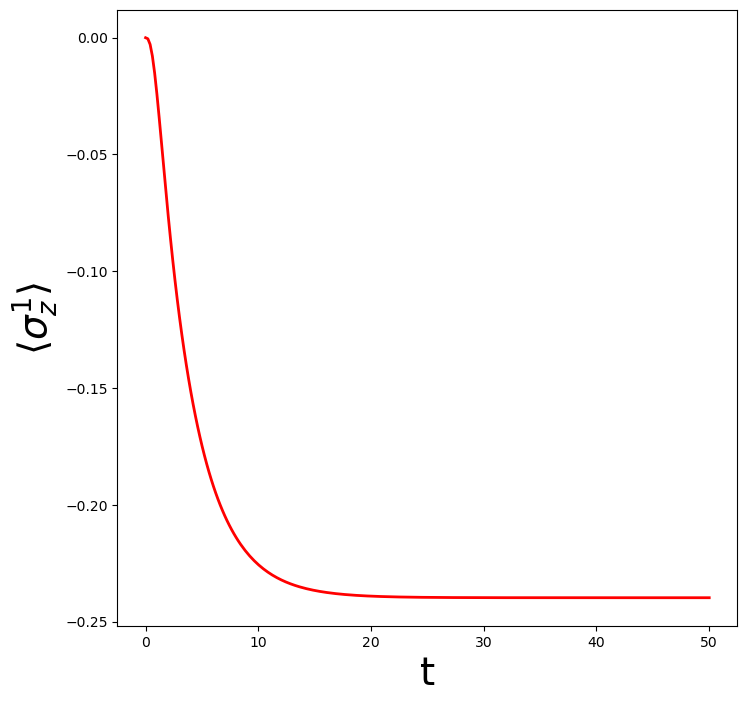

In [9]:
fig, axes = plt.subplots(figsize=(8, 8))
axes.plot(tlist, result.expect[0], 'r', linewidth=2)
axes.set_xlabel('t', fontsize=28)
axes.set_ylabel(r"$\langle \sigma_z^1 \rangle$", fontsize=28);

We find a rather quick thermalization of the system state. For the heat currents, however, it takes a somewhat longer time until they converge to their long-time values:

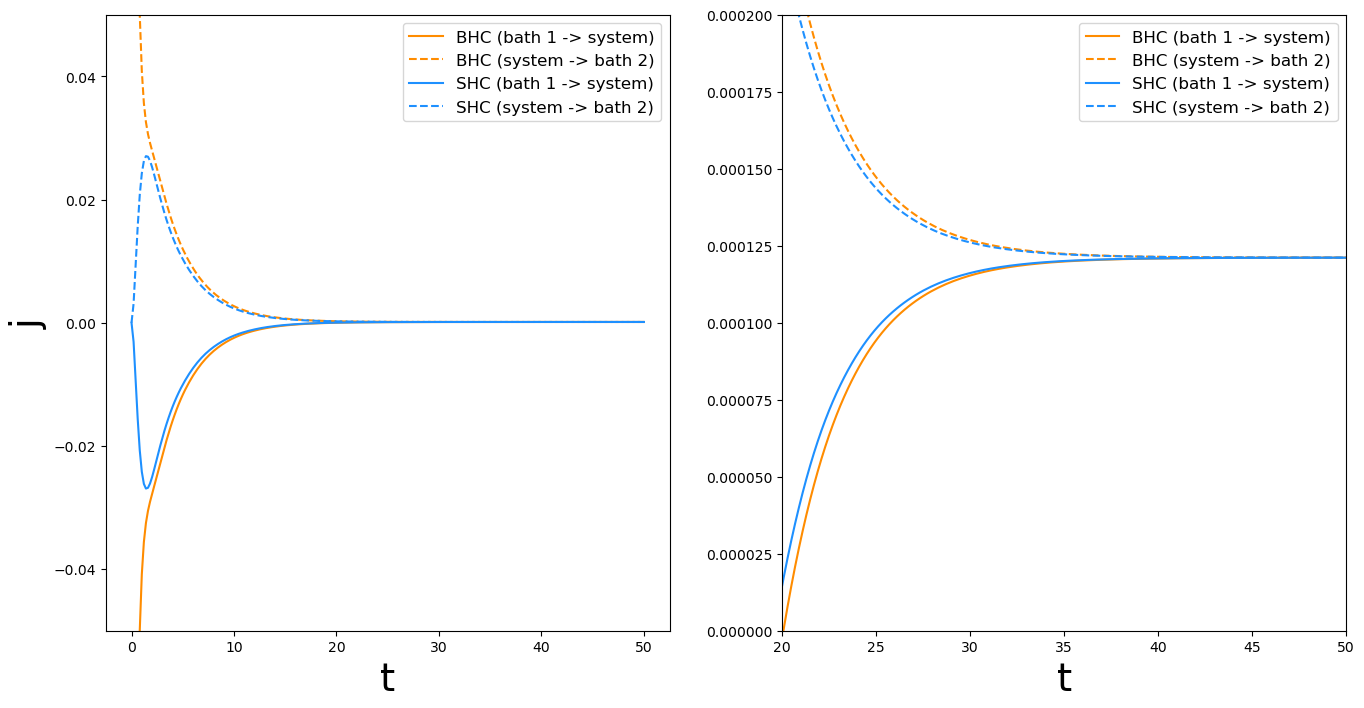

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

ax1.plot(
    tlist, -np.real(result.expect[1]),
    color='darkorange', label='BHC (bath 1 -> system)',
)
ax1.plot(
    tlist, np.real(result.expect[2]),
    '--', color='darkorange', label='BHC (system -> bath 2)',
)
ax1.plot(
    tlist, -np.real(result.expect[3]),
    color='dodgerblue', label='SHC (bath 1 -> system)',
)
ax1.plot(
    tlist, np.real(result.expect[4]),
    '--', color='dodgerblue', label='SHC (system -> bath 2)',
)

ax1.set_xlabel('t', fontsize=28)
ax1.set_ylabel('j', fontsize=28)
ax1.set_ylim((-0.05, 0.05))
ax1.legend(loc=0, fontsize=12)

ax2.plot(
    tlist, -np.real(result.expect[1]),
    color='darkorange', label='BHC (bath 1 -> system)',
)
ax2.plot(
    tlist, np.real(result.expect[2]),
    '--', color='darkorange', label='BHC (system -> bath 2)',
)
ax2.plot(
    tlist, -np.real(result.expect[3]),
    color='dodgerblue', label='SHC (bath 1 -> system)',
)
ax2.plot(
    tlist, np.real(result.expect[4]),
    '--', color='dodgerblue', label='SHC (system -> bath 2)',
)

ax2.set_xlabel('t', fontsize=28)
ax2.set_xlim((20, 50))
ax2.set_ylim((0, 0.0002))
ax2.legend(loc=0, fontsize=12);

### Steady-state currents

Here, we try to reproduce the HEOM curves in Fig. 3(a) of Ref. \[1\] by varying the coupling strength and finding the steady state for each coupling strength.

In [11]:
def heat_currents(sys, bath_p1, bath_p2, Nk, NC, options):
    """ Calculate the steady sate heat currents for the given system and
        bath.
    """
    bath1 = bath_p1.bath(Nk, tag="bath 1")
    Q1 = bath_p1.Q()

    bath2 = bath_p2.bath(Nk, tag="bath 2")
    Q2 = bath_p2.Q()

    b1delta, b1term = bath1.terminator()
    b2delta, b2term = bath2.terminator()

    solver = HEOMSolver(
        qt.liouvillian(sys.H()) + b1term + b2term,
        [bath1, bath2],
        max_depth=NC,
        options=options
    )

    _, steady_ados = solver.steady_state()

    return (
        bath_heat_current('bath 1', steady_ados, sys.H(), Q1, b1delta),
        bath_heat_current('bath 2', steady_ados, sys.H(), Q2, b2delta),
        system_heat_current('bath 1', steady_ados, sys.H(), Q1, b1delta),
        system_heat_current('bath 2', steady_ados, sys.H(), Q2, b2delta),
    )

In [12]:
# Define number of points to use for the plot
plot_points = 10  # use 100 for a smoother curve

# Range of relative coupling strengths
# Chosen so that zb_max is maximum, centered around 1 on a log scale
zb_max = 4  # use 20 to see more of the current curve
zeta_bars = np.logspace(
    -np.log(zb_max),
    np.log(zb_max),
    plot_points,
    base=np.e,
)

# Setup a progress bar
progress = IntProgress(min=0, max=(3 * plot_points))
display(progress)


def calculate_heat_current(J12, zb, Nk, progress=progress):
    """ Calculate a single heat current and update the progress bar. """
    # Estimate appropriate HEOM max_depth from coupling strength
    NC = 7 + int(max(zb * J12 - 1, 0) * 2)
    NC = min(NC, 20)
    # the four currents are identical in the steady state
    j, _, _, _ = heat_currents(
        sys.replace(J12=J12),
        bath_p1.replace(lam=zb * J12 / 2),
        bath_p2.replace(lam=zb * J12 / 2),
        Nk, NC, options=options,
    )
    progress.value += 1
    return j


# Calculate steady state currents for range of zeta_bars
# for J12 = 0.01, 0.1 and 0.5:
j1s = [
    calculate_heat_current(0.01, zb, Nk)
    for zb in zeta_bars
]
j2s = [
    calculate_heat_current(0.1, zb, Nk)
    for zb in zeta_bars
]
j3s = [
    calculate_heat_current(0.5, zb, Nk)
    for zb in zeta_bars
]

IntProgress(value=0, max=30)

## Create Plot

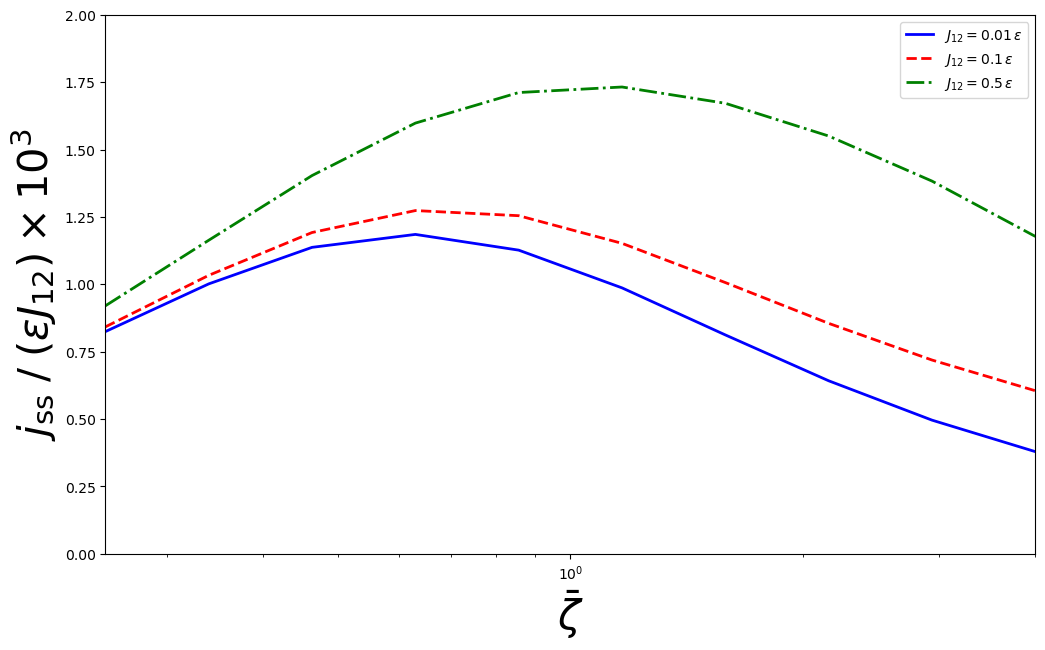

In [13]:
fig, axes = plt.subplots(figsize=(12, 7))

axes.plot(
    zeta_bars, -1000 * 100 * np.real(j1s),
    'b', linewidth=2, label=r"$J_{12} = 0.01\, \epsilon$",
)
axes.plot(
    zeta_bars, -1000 * 10 * np.real(j2s),
    'r--',  linewidth=2, label=r"$J_{12} = 0.1\, \epsilon$",
)
axes.plot(
    zeta_bars, -1000 * 2 * np.real(j3s),
    'g-.', linewidth=2, label=r"$J_{12} = 0.5\, \epsilon$",
)

axes.set_xscale('log')
axes.set_xlabel(r"$\bar\zeta$", fontsize=30)
axes.set_xlim((zeta_bars[0], zeta_bars[-1]))

axes.set_ylabel(
    r"$j_{\mathrm{ss}}\; /\; (\epsilon J_{12}) \times 10^3$",
    fontsize=30,
)
axes.set_ylim((0, 2))

axes.legend(loc=0);

## About

In [14]:
qt.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0.dev0+4033695
Numpy Version:      2.2.4
Scipy Version:      1.15.2
Cython Version:     3.0.12
Matplotlib Version: 3.10.1
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------



qutip-jax: 0.1.1.dev5
qutip-qtrl: 0.2.0.dev0+acb71a0
qutip-qip: 0.5.0.dev0+d58a82d

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


## Testing

This section can include some tests to verify that the expected outputs are generated within the notebook. We put this section at the end of the notebook, so it's not interfering with the user experience. Please, define the tests using assert, so that the cell execution fails if a wrong output is generated.

In [15]:
assert 1 == 1